In [1]:
import os
folder_pwd = os.getcwd()
os.chdir('..')
os.chdir('../resources')
resources_path = os.getcwd()
os.chdir(folder_pwd)

image_folder = "/test/Images"
csv_folder = '/test/c'

files = os.listdir(resources_path+csv_folder)
csv_file = []
for f in files:
    csv_file.append(f)

csv_file

['Batch10.csv - TEST.csv', 'Batch11.csv TEST.csv', 'Batch9.csv - TEST.csv']

In [2]:
%%time
from csv import reader
import pandas as pd
import numpy as np

def read_csv(file_name):
    return pd.read_csv(resources_path+csv_folder+'/'+file_name, names=['type','from_x','from_y','width', 'height', 'name', 'full_width', 'full_height'])

df = pd.DataFrame()
for f in csv_file:
    df = df.append(read_csv(f)).reset_index(drop=True)
df

Wall time: 349 ms


,type,from_x,from_y,width,height,name,full_width,full_height
0,Head,401,218,199,178,20170_2021-02-17_23.26_231242218.png,800,480
1,Head,414,190,194,173,20170_2021-02-17_23.26_23155437.png,800,480
2,Spine,360,121,165,76,20176_2021-02-18_14.12_1478842.png,800,480
3,Head,353,157,200,169,20180_2021-02-14_10.40_103946538.png,800,480
4,Head,429,141,133,125,20185_2021-02-19_14.07_14130658.png,800,480
...,...,...,...,...,...,...,...,...
432,Head,310,106,88,86,21273_2021-04-26_20.02_195224108.png,800,480
433,Hands,421,124,36,24,21273_2021-04-26_20.02_195224108.png,800,480
434,Head,256,101,109,102,21273_2021-04-26_20.13_20739369.png,800,480
435,Head,329,129,92,88,21277_2021-04-27_20.23_201955591.png,800,480


In [3]:
print(df['type'].unique())
df = df.rename(columns={'from_x':'from_y', 'from_y':'from_x'})
df = df.replace({'Head ':'head','Head':'head','Arms':'arm','Spine ':'spine','Legs':'leg','Feet':'foot','Spine':'spine', 'Hands':'hand'})
print(df['type'].unique(),'\n' ,df.groupby('type').count()['from_x'])
df

['Head ' 'Spine' 'Arms' 'Hands' 'Legs' 'Head']
['head' 'spine' 'arm' 'hand' 'leg'] 
 type
arm        7
hand      11
head     343
leg        2
spine     74
Name: from_x, dtype: int64


,type,from_y,from_x,width,height,name,full_width,full_height
0,head,401,218,199,178,20170_2021-02-17_23.26_231242218.png,800,480
1,head,414,190,194,173,20170_2021-02-17_23.26_23155437.png,800,480
2,spine,360,121,165,76,20176_2021-02-18_14.12_1478842.png,800,480
3,head,353,157,200,169,20180_2021-02-14_10.40_103946538.png,800,480
4,head,429,141,133,125,20185_2021-02-19_14.07_14130658.png,800,480
...,...,...,...,...,...,...,...,...
432,head,310,106,88,86,21273_2021-04-26_20.02_195224108.png,800,480
433,hand,421,124,36,24,21273_2021-04-26_20.02_195224108.png,800,480
434,head,256,101,109,102,21273_2021-04-26_20.13_20739369.png,800,480
435,head,329,129,92,88,21277_2021-04-27_20.23_201955591.png,800,480


In [4]:
images_to_check =df['name'].unique()
images_to_check.shape

(370,)

In [5]:
%%time

import os, random, cv2, Classify
import numpy as np

# 1. Load models
classifiers = Classify.load_svm(resources_path + '/SVM')
print(classifiers)

{'head': SVC(probability=True), 'spine': SVC(probability=True), 'leg': SVC(probability=True), 'arm': SVC(probability=True), 'foot': SVC(probability=True), 'hand': SVC(probability=True)}
Wall time: 1.06 s


In [8]:
%%time
import time
from joblib import Parallel, delayed

def analyse(image):
    print(image, end=' ')
    img = cv2.imread(resources_path+image_folder+'/'+image, 0)
    
    start = time.time()

    feat_image, result, pred = Classify.analyse_image(img, classifiers,  crop_thresh=0.2, blur_size=10, bright_strength=1, sharp_strength=1,
                                   square_step=True, windows=[(64, 64), (96, 96), (128, 128), (192, 192)], window_stride=16, pred_threshold = 0.99)
    
    end = time.time()
    result['time_in_s'] = end-start
    result['name'] = image
    result.to_csv(resources_path+'/test/res/'+image[0:-4]+'.csv')

for im in images_to_check[142:]:
    analyse(im)


20300_2021-02-17_20.03_20218318.png 20300_2021-02-18_09.35_93042669.png 20303_2021-02-19_07.47_74218915.png 20306_2021-02-23_20.04_20324991.png 20306_2021-02-23_23.43_23382129.png 20306_2021-02-23_23.43_2339489.png 20306_2021-02-23_23.43_23432328.png 20309_2021-03-05_16.45_164433683.png 20315_2021-02-23_18.11_18419593.png 20318_2021-02-16_18.52_185058927.png 20318_2021-02-16_19.09_19531460.png 20345_2021-03-03_13.49_134145859.png 20345_2021-03-03_19.10_19310149.png 20357_2021-02-19_22.32_2224889.png 20366_2021-02-17_20.31_202559108.png 

KeyboardInterrupt: 

In [82]:
files = os.listdir(resources_path+'/test/res')
csv_file = []
for f in files:
    
    csv_file.append(pd.read_csv(resources_path+'/test/res/'+f))

results = pd.concat(csv_file)
results[["x", "y"]] = results[["x", "y"]].apply(pd.to_numeric, downcast='integer')
results['window_size'] = results['window_size'].apply(ast.literal_eval)

In [170]:
import ast

results1 = results.rename(columns={'highest': 'type'}).drop(columns=['hog', 'window'])
results1 = pd.merge(df, results1, on=['name', 'type'], how='outer')

results1 = results1.drop(columns=['full_width', 'full_height', 'head', 'spine', 'leg', 'hand', 'arm' , 'foot'])

In [171]:
from Classify import iou_value

def iou(row):
    if row.isnull().values.any():
        return 0
    c, c1 = row[['from_x','from_y']], row[['x','y']]
    boxA = [c[0], c[1], c[0]+row['width'], c[1]+row['height']]
    boxB = [c1[0], c1[1], c1[0]+row['window_size'][0], c1[1]+row['window_size'][1]]
    return iou_value(boxA, boxB, boxes=True)


def t(df):

    true_positive = len(df[df['iou']>0.5])
    false_negative = df['x'].isna().sum()
    false_positive = df['from_x'].isna().sum()
    print('{} tp {} fp {} fn'.format(true_positive, false_positive, false_negative))

results1.loc[:,'iou'] = results1.apply(iou, axis=1)
t(results1)
t(results1[results1['type']=='head'])
t(results1[results1['type']=='spine'])
t(results1[results1['type']=='arm'])
t(results1[results1['type']=='hand'])
t(results1[results1['type']=='leg'])
results1

75 tp 52 fp 319 fn
75 tp 4 fp 243 fn
0 tp 44 fp 56 fn
0 tp 0 fp 7 fn
0 tp 4 fp 11 fn
0 tp 0 fp 2 fn


,type,from_y,from_x,width,height,name,Unnamed: 0,x,y,window_size,highest_pred,time_in_s,iou
0,head,401.0,218.0,199.0,178.0,20170_2021-02-17_23.26_231242218.png,1487,195.0,400.0,"(192, 192)",0.995305,25.944332,0.714001
1,head,414.0,190.0,194.0,173.0,20170_2021-02-17_23.26_23155437.png,1536,178.0,409.0,"(192, 192)",0.997521,27.173122,0.793600
2,spine,360.0,121.0,165.0,76.0,20176_2021-02-18_14.12_1478842.png,1725,64.0,374.0,"(192, 192)",0.999999,34.483777,0.206642
3,head,353.0,157.0,200.0,169.0,20180_2021-02-14_10.40_103946538.png,2057,144.0,355.0,"(192, 192)",0.999878,42.801647,0.734355
4,head,429.0,141.0,133.0,125.0,20185_2021-02-19_14.07_14130658.png,1369,128.0,438.0,"(128, 128)",0.993705,36.805249,0.680198
...,...,...,...,...,...,...,...,...,...,...,...,...,...
484,hand,NaN,NaN,NaN,NaN,21012_2021-03-31_12.22_121256641.png,492,304.0,325.0,"(64, 64)",0.992224,43.902896,0.000000
485,spine,NaN,NaN,NaN,NaN,21044_2021-04-17_00.45_231438455.png,1409,128.0,321.0,"(128, 128)",0.995905,45.427071,0.000000
486,spine,NaN,NaN,NaN,NaN,21151_2021-04-09_21.36_213632947.png,1890,144.0,194.0,"(192, 192)",0.990607,45.794574,0.000000
487,spine,NaN,NaN,NaN,NaN,21192_2021-04-13_16.49_164318693.png,1913,160.0,194.0,"(192, 192)",0.994912,44.772137,0.000000


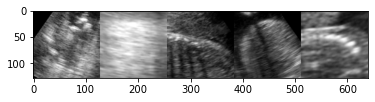

In [172]:
from matplotlib import pyplot as plt

import cv2

def extract_subsection1(row):
    img = cv2.imread(resources_path+image_folder+'/'+row['name'], 0)
    
    if img is None:
        return np.nan
    
    subsect = img[int(row['from_x']):int(row['from_x']+row['width']), int(row['from_y']):int(row['from_y']+row['height'])]
    # In case the crop was near an edge, creating the square could make it go outside image
    if subsect.shape[0] != subsect.shape[1]:
        diff = subsect.shape[0] - subsect.shape[1]
        if diff<0:
            subsect = np.pad(subsect, ((0, abs(diff)),(0,0)),constant_values=0)
        else:
            subsect = np.pad(subsect, ((0, 0),(0, abs(diff))),constant_values=0)
    subsect = cv2.resize(subsect, (128, 128))
    return subsect

def extract_subsection(row):
    img = cv2.imread(resources_path+image_folder+'/'+row['name'], 0)
    
    if img is None:
        return np.nan
    subsect = img[int(row['x']):int(row['x']+row['window_size'][0]), int(row['y']):int(row['y']+row['window_size'][0])]
    # In case the crop was near an edge, creating the square could make it go outside image
    if subsect.shape[0] != subsect.shape[1]:
        diff = subsect.shape[0] - subsect.shape[1]
        if diff<0:
            subsect = np.pad(subsect, ((0, abs(diff)),(0,0)),constant_values=0)
        else:
            subsect = np.pad(subsect, ((0, 0),(0, abs(diff))),constant_values=0)
    subsect = cv2.resize(subsect, (128, 128))
    return subsect

t = results1.copy(deep=True)#[results1['window_size']==(64, 64)]
t = t.dropna(subset=['x'])
t['subsection'] = t.apply(extract_subsection, axis=1)
t = t.dropna().sort_values(by='iou')

plt.imshow(np.concatenate(t['subsection'].head(5).values, axis=1), cmap = 'gray')

In [173]:
t.dropna().sort_values(by='iou')

,type,from_y,from_x,width,height,name,Unnamed: 0,x,y,window_size,highest_pred,time_in_s,iou,subsection
24,head,406.0,139.0,111.0,90.0,20318_2021-02-18_11.12_1110181.png,1909,208.0,150.0,"(192, 192)",0.995187,38.364178,0.000000,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
103,head,362.0,122.0,112.0,122.0,20862_2021-04-09_12.36_123531930.png,1118,305.0,293.0,"(96, 96)",0.999250,44.766416,0.000000,"[[140, 144, 147, 150, 151, 153, 153, 148, 139,..."
31,spine,397.0,195.0,342.0,137.0,20385_2021-02-18_12.11_12142941.png,3808,160.0,560.0,"(192, 192)",0.994231,83.851093,0.000000,"[[145, 150, 153, 162, 172, 173, 165, 153, 157,..."
8,head,223.0,102.0,231.0,229.0,20208_2021-05-01_20.13_20851214.png,1906,195.0,454.0,"(192, 192)",0.999385,36.392724,0.000000,"[[4, 4, 6, 6, 4, 5, 6, 7, 11, 14, 19, 32, 55, ..."
38,spine,461.0,238.0,206.0,105.0,20433_2021-03-07_21.04_20543041.png,1935,224.0,576.0,"(96, 96)",0.997392,84.579819,0.000000,"[[75, 74, 75, 79, 83, 83, 84, 86, 90, 93, 93, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11,head,281.0,155.0,115.0,118.0,20256_2021-02-26_18.29_18205356.png,1385,145.0,277.0,"(128, 128)",0.999237,37.822521,0.829517,"[[107, 125, 132, 132, 128, 121, 111, 94, 79, 8..."
154,head,460.0,95.0,95.0,97.0,20300_2021-02-18_09.35_93042669.png,764,97.0,454.0,"(96, 96)",0.995826,33.991997,0.833479,"[[127, 119, 121, 129, 109, 84, 82, 101, 109, 1..."
138,head,468.0,170.0,123.0,134.0,20191_2021-02-23_22.50_225026223.png,1449,176.0,470.0,"(128, 128)",0.997609,42.853165,0.838262,"[[105, 105, 104, 104, 99, 89, 83, 85, 90, 93, ..."
120,head,275.0,173.0,135.0,144.0,21206_2021-04-14_21.52_214417458.png,1437,176.0,277.0,"(128, 128)",0.999926,44.099790,0.843864,"[[62, 64, 76, 79, 83, 82, 85, 84, 73, 64, 61, ..."
